In [1]:
import datetime
print('Last updated: ', datetime.datetime.now(), '(PT)')

Last updated:  2020-06-29 18:26:10.775102 (PT)


In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
# from pyro.optim import Adam
# from pyro.infer import SVI, Trace_ELBO
# from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
# from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS, HMC
import torch
import torch.distributions.constraints as constraints
from torch.nn.functional import pad
from tqdm import trange

# For ADVI
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

In [3]:
# Stick break function
# See: https://pyro.ai/examples/dirichlet_process_mixture.html
def stickbreak(v):
    # cumprod_one_minus_v = torch.log1p(-v).cumsum(-1).exp()
    cumprod_one_minus_v = torch.cumprod(1 - v, dim=-1)
    one_v = pad(v, (0, 1), value=1)
    c_one = pad(cumprod_one_minus_v, (1, 0), value=1)
    return one_v * c_one

In [4]:
# NOTE: This resulted in poor inference.
class GMM(dist.Distribution):
    def __init__(self, mu, sigma, w):
        self.mu = mu
        self.sigma = sigma
        self.w = w
    
    def sample(self, sample_shape=()):
        return torch.zeros((1, ) + sample_shape)
    
    def log_prob(self, y, dim=-1):
        lp = dist.Normal(self.mu, self.sigma).log_prob(y) + torch.log(self.w)
        return lp.logsumexp(dim=dim)

# Example:
# mu = torch.randn(1, 3)
# sigma = torch.rand(1, 3)
# w = stickbreak(torch.rand(1, 2))
# y = torch.randn(10, )
# GMM(mu, sigma, w).log_prob(y[:, None])

In [5]:
# See: https://pyro.ai/examples/gmm.html#
# See: https://pyro.ai/examples/dirichlet_process_mixture.html
# See: https://forum.pyro.ai/t/fitting-models-with-nuts-is-slow/1900

# DP SB GMM model.
# NOTE: In pyro, priors are assigned to parameters in the following manner:
#
#   random_variable = pyro.sample('name_of_random_variable', some_distribution)
#
# Note that random variables appear on the left hand side of the `pyro.sample` statement.
# Data will appear *inside* the `pyro.sample` statement, via the obs argument.
# 
# In this example, labels are explicitly mentioned. But they are, in fact, marginalized
# out automatically by pyro. Hence, they do not appear in the posterior samples.
#
# Both marginalized and auxiliary variabled versions are equally slow.
def dp_sb_gmm(y, num_components):
    # Cosntants
    N = y.shape[0]
    K = num_components
    
    # Priors
    # NOTE: In pyro, the Gamma distribution is parameterized with shape and rate.
    # Hence, Gamma(shape, rate) => mean = shape/rate
    alpha = pyro.sample('alpha', dist.Gamma(1, 10))
    
    with pyro.plate('mixture_weights', K - 1):
        v = pyro.sample('v', dist.Beta(1, alpha, K - 1))
    
    eta = stickbreak(v)
    
    with pyro.plate('components', K):
        mu = pyro.sample('mu', dist.Normal(0., 3.))
        sigma = pyro.sample('sigma', dist.Gamma(1, 10))

    with pyro.plate('data', N):
        # For marginalized version.
        # pyro.sample('obs', GMM(mu[None, :], sigma[None, :], eta[None, :]), obs=y[:, None])
        # Local variables.
        label = pyro.sample('label', dist.Categorical(eta), infer={"enumerate": "parallel"})
        pyro.sample('obs', dist.Normal(mu[label], sigma[label]), obs=y)

In [6]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
  simdata = json.load(f)

In [7]:
# Convert data to torch.tensor.
y = torch.tensor(simdata['y'])

100%|██████████| 2000/2000 [00:15<00:00, 126.50it/s]

CPU times: user 47.4 s, sys: 87.3 ms, total: 47.5 s
Wall time: 15.8 s


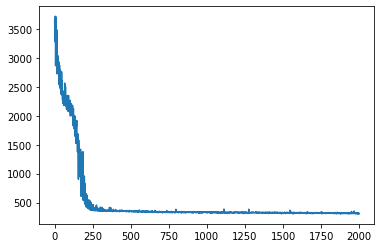

In [8]:
%%time 

# See: https://pyro.ai/examples/dirichlet_process_mixture.html

pyro.clear_param_store()

# Automatically define variational distribution.
guide = AutoDiagonalNormal(
    pyro.poutine.block(dp_sb_gmm, expose=['alpha', 'v', 'mu', 'sigma'])
)  # a mean field guide

svi = SVI(dp_sb_gmm, guide, Adam({'lr': 1e-2}), TraceEnum_ELBO())

# pyro.set_rng_seed(4)
pyro.set_rng_seed(7)

# do gradient steps
loss = []
for step in trange(2000):
    _loss = svi.step(y, 10)
    loss.append(_loss)
    
# Plot ELBO    
plt.plot(loss);

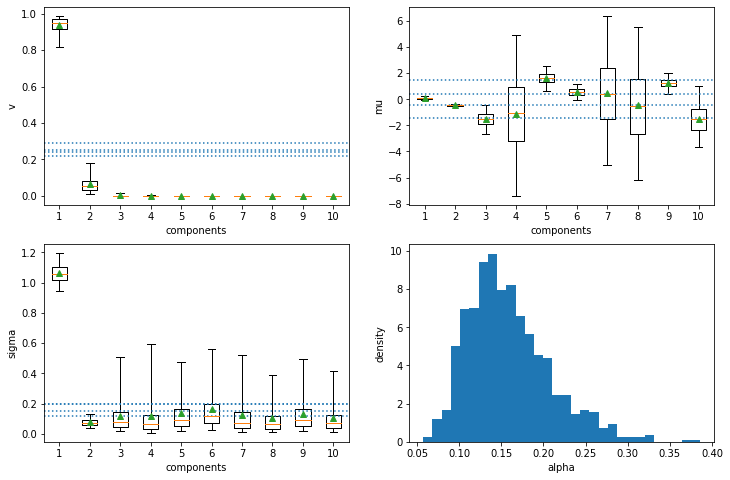

In [9]:
samples = guide.get_posterior().sample((1000, ))
alpha = samples[:, 0].exp()
v = samples[:, 1:10].sigmoid()
mu = samples[:, 10:20]
sigma = samples[:, 20:30].exp()

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.boxplot(stickbreak(v).numpy(), whis=[2.5, 97.5], showmeans=True, showfliers=False)
for line in simdata['w']: plt.axhline(line, ls=":")
plt.xlabel('components')
plt.ylabel('v')

plt.subplot(2, 2, 2)
plt.boxplot(mu.numpy(), whis=[2.5, 97.5], showmeans=True, showfliers=False)
for line in simdata['mu']: plt.axhline(line, ls=":")
plt.xlabel('components')
plt.ylabel('mu')

plt.subplot(2, 2, 3)
plt.boxplot(sigma.numpy(), whis=[2.5, 97.5], showmeans=True, showfliers=False)
for line in simdata['sig']: plt.axhline(line, ls=":")
plt.xlabel('components')
plt.ylabel('sigma')

plt.subplot(2, 2, 4)
plt.hist(alpha.numpy(), bins=30, density=True)
plt.xlabel('alpha')
plt.ylabel('density');

In [10]:
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Set up HMC sampler.
kernel = HMC(dp_sb_gmm, step_size=0.01, trajectory_length=1, target_accept_prob=0.8,
             adapt_step_size=False, adapt_mass_matrix=False)
# kernel = HMC(dp_sb_gmm, step_size=0.01, trajectory_length=1, target_accept_prob=0.8)
hmc = MCMC(kernel, num_samples=500, warmup_steps=500)
hmc.run(y, 10)

# 06:13 for marginalized version.

# Get posterior samples
hmc_posterior_samples = hmc.get_samples()
hmc_posterior_samples['eta'] = stickbreak(hmc_posterior_samples['v'])

Sample: 100%|██████████| 1000/1000 [09:44,  1.71it/s, step size=1.00e-02, acc. prob=0.928]


In [11]:
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Set up NUTS sampler.
kernel = NUTS(dp_sb_gmm, target_accept_prob=0.8)
nuts = MCMC(kernel, num_samples=500, warmup_steps=500)
nuts.run(y, 10)

# 44:07 for marginalized version.

# Get posterior samples
nuts_posterior_samples = nuts.get_samples()
nuts_posterior_samples['eta'] = stickbreak(nuts_posterior_samples['v'])

Sample: 100%|██████████| 1000/1000 [1:17:58,  4.68s/it, step size=2.50e-04, acc. prob=0.807]


In [12]:
def plot_param_post(params, param_name, param_full_name, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)
    param = params[param_name].numpy()

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    plt.subplot(1, 2, 2)
    plt.plot(param);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

In [13]:
def plot_all_params(params):
    plot_param_post(params, 'eta', 'mixture weights', truth=simdata['w'])
    plot_param_post(params, 'mu', 'mixture locations', truth=simdata['mu'])
    plot_param_post(params, 'sigma', 'mixture scales', truth=simdata['sig'])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(params['alpha'], bins=30, density=True);
    plt.xlabel("alpha")
    plt.ylabel("density")
    plt.title("Posterior distribution of alpha");

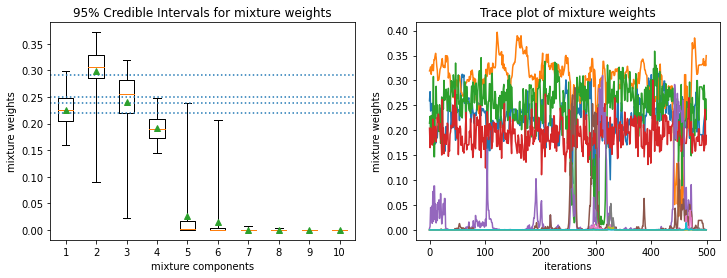

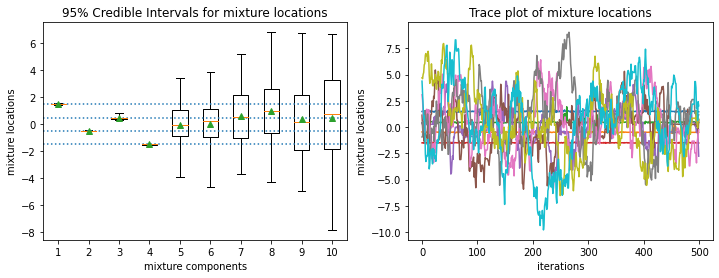

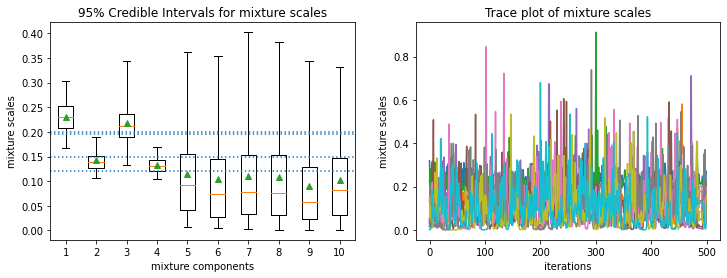

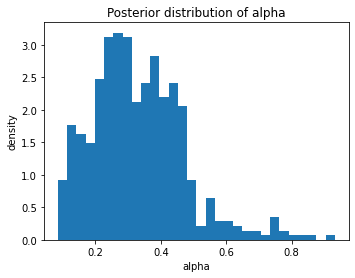

In [14]:
plot_all_params(hmc_posterior_samples)

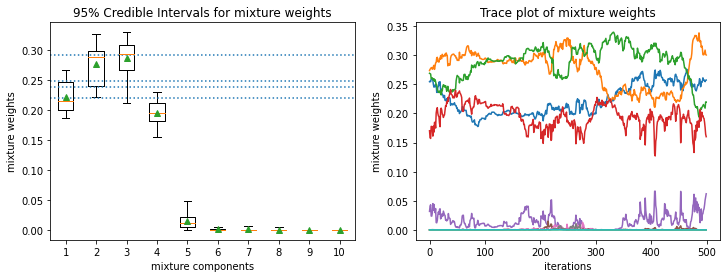

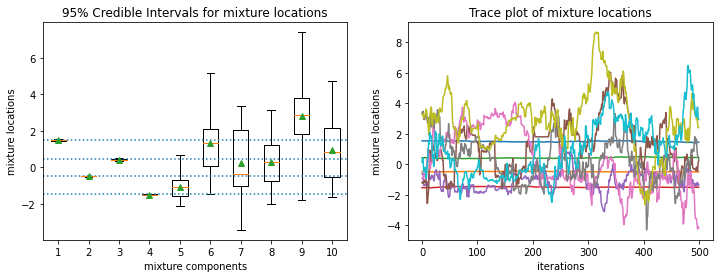

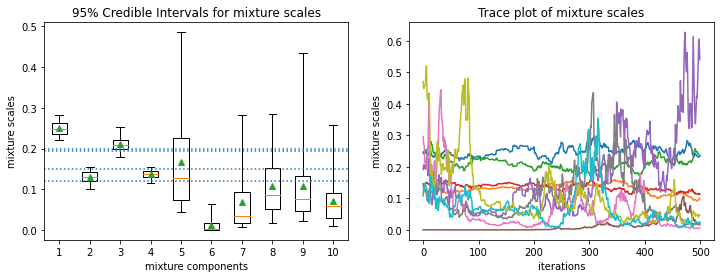

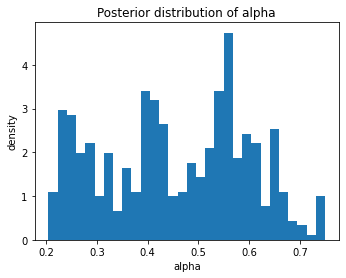

In [15]:
plot_all_params(nuts_posterior_samples)